In [1]:
from IPython.display import clear_output
!pip install tf_explain
clear_output()


In [2]:
import os
import keras
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
import tensorflow.image as tfi

from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# Data Viz
import matplotlib.pyplot as plt

# Model 
from keras.models import Model
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import UpSampling2D
from keras.layers import concatenate
from keras.layers import Add
from keras.layers import Multiply
from keras.layers import Input
from keras.layers import MaxPool2D
from keras.layers import BatchNormalization

# Callbacks 
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tf_explain.core.grad_cam import GradCAM

# Metrics
from keras.metrics import MeanIoU


2025-06-21 09:24:21.901098: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-21 09:24:23.844484: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750478064.466282    7889 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750478064.627209    7889 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750478066.349808    7889 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
def load_image(image, SIZE):
    return np.round(tfi.resize(img_to_array(load_img(image))/255.,(SIZE, SIZE)),4)

def load_images(image_paths, SIZE, mask=False, trim=None):
    if trim is not None:
        image_paths = image_paths[:trim]
    
    if mask:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 1))
    else:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))
    
    for i,image in enumerate(image_paths):
        img = load_image(image,SIZE)
        if mask:
            images[i] = img[:,:,:1]
        else:
            images[i] = img
    
    return images

In [4]:
def show_image(image, title=None, cmap=None, alpha=1):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def show_mask(image, mask, cmap=None, alpha=0.4):
    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')
    


In [5]:
SIZE = 256
root_path = 'images'
classes = sorted(os.listdir(root_path))
classes

['Cancer', 'Non-Cancer']

In [6]:
#single_mask_paths = sorted([sorted(glob(root_path + name + "*mask.png")) for name in classes])
#double_mask_paths = sorted([sorted(glob(root_path + name + "*mask_1.png")) for name in classes])
#single_mask_paths = sorted([sorted(glob(root_path + name + "/*mask.png")) for name in classes])
#single_mask_paths = sorted([
 #   sorted(glob(os.path.join(root_path, name, "/*mask.jpg"))) 
  #  for name in classes
#print(f"Classes found: {classes}")
#print(f"Number of image paths: {len(image_paths)}")


In [7]:
#image_paths = []
#mask_paths = []
#for class_path in single_mask_paths:
 #   for path in class_path:
  #      img_path = path.replace('_mask','')
   #     image_paths.append(img_path)
    #    mask_paths.append(path)


In [8]:
#show_image(load_image(image_paths[1], SIZE))

In [9]:
from glob import glob
import os

root_path = 'images'
classes = sorted(os.listdir(root_path))

single_mask_paths = sorted([
    sorted(glob(os.path.join(root_path, name, "*_mask.jpg")))
    for name in classes
])

image_paths = []
mask_paths = []

for class_masks in single_mask_paths:
    for mask_path in class_masks:
        img_path = mask_path.replace('_mask', '')  # removes `_mask` from filename
        image_paths.append(img_path)
        mask_paths.append(mask_path)

print(f"Found {len(image_paths)} image-mask pairs.")
print("Sample image:", image_paths[0] if image_paths else "None")
print("Sample mask:", mask_paths[0] if mask_paths else "None")
print(f"Classes found: {classes}")
print(f"Number of image paths: {len(image_paths)}")



Found 745 image-mask pairs.
Sample image: images/Cancer/IMG (1).jpg
Sample mask: images/Cancer/IMG (1)_mask.jpg
Classes found: ['Cancer', 'Non-Cancer']
Number of image paths: 745


2025-06-21 09:24:46.618771: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


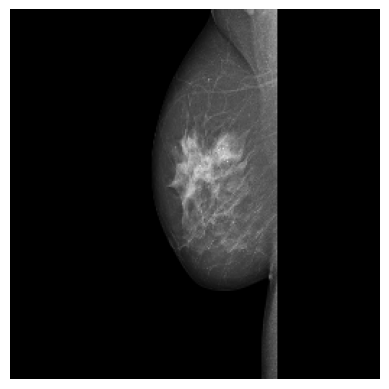

In [10]:
show_image(load_image(image_paths[0], SIZE))

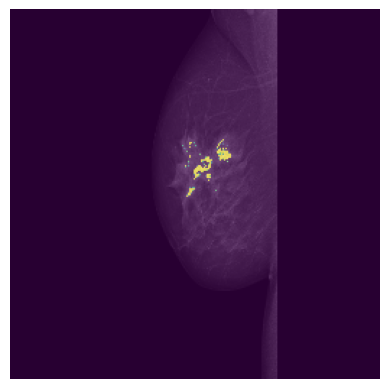

In [11]:
show_mask(load_image(image_paths[0], SIZE), load_image(mask_paths[0], SIZE)[:,:,0], alpha=0.6)


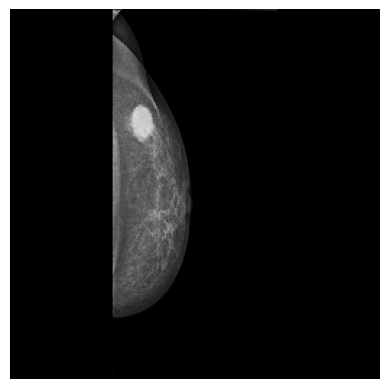

In [12]:
show_image(load_image('images/Cancer/IMG (23).jpg', SIZE))

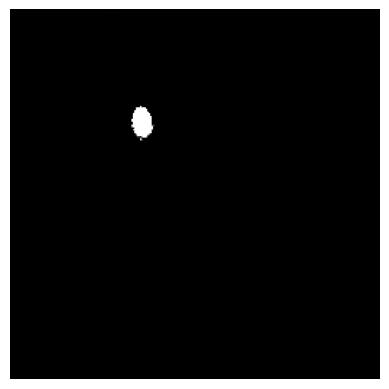

In [13]:
show_image(load_image('images/Cancer/IMG (23)_mask.jpg', SIZE))

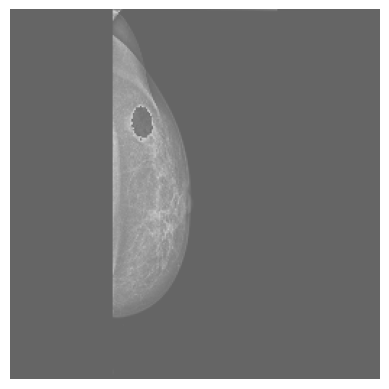

In [14]:
img = np.zeros((1,SIZE,SIZE,3))
#mask1 = load_image('Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png', SIZE)
mask2 = load_image('images/Cancer/IMG (23)_mask.jpg', SIZE)

img = img +  mask2
img = img[0,:,:,0]
show_image(img, cmap='gray')

show_image(load_image('images/Cancer/IMG (23).jpg', SIZE))
plt.imshow(img, cmap='binary', alpha=0.4)
plt.axis('off')
plt.show()

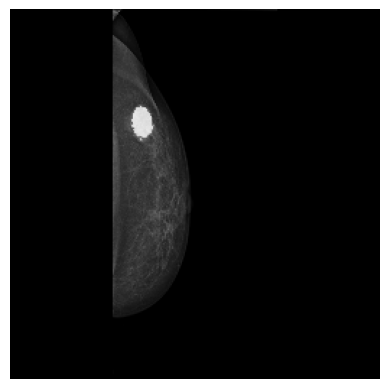

In [15]:
show_image(load_image('images/Cancer/IMG (23).jpg', SIZE))
plt.imshow(img, cmap='gray', alpha=0.4)
plt.axis('off')
plt.show()


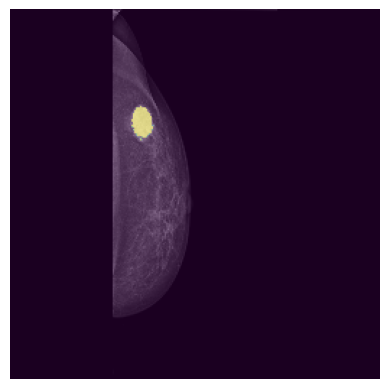

In [16]:
show_image(load_image('images/Cancer/IMG (23).jpg', SIZE))
plt.imshow(img, alpha=0.4)
plt.axis('off')
plt.show()


In [17]:
images = load_images(image_paths, SIZE)
masks = load_images(mask_paths, SIZE, mask=True)



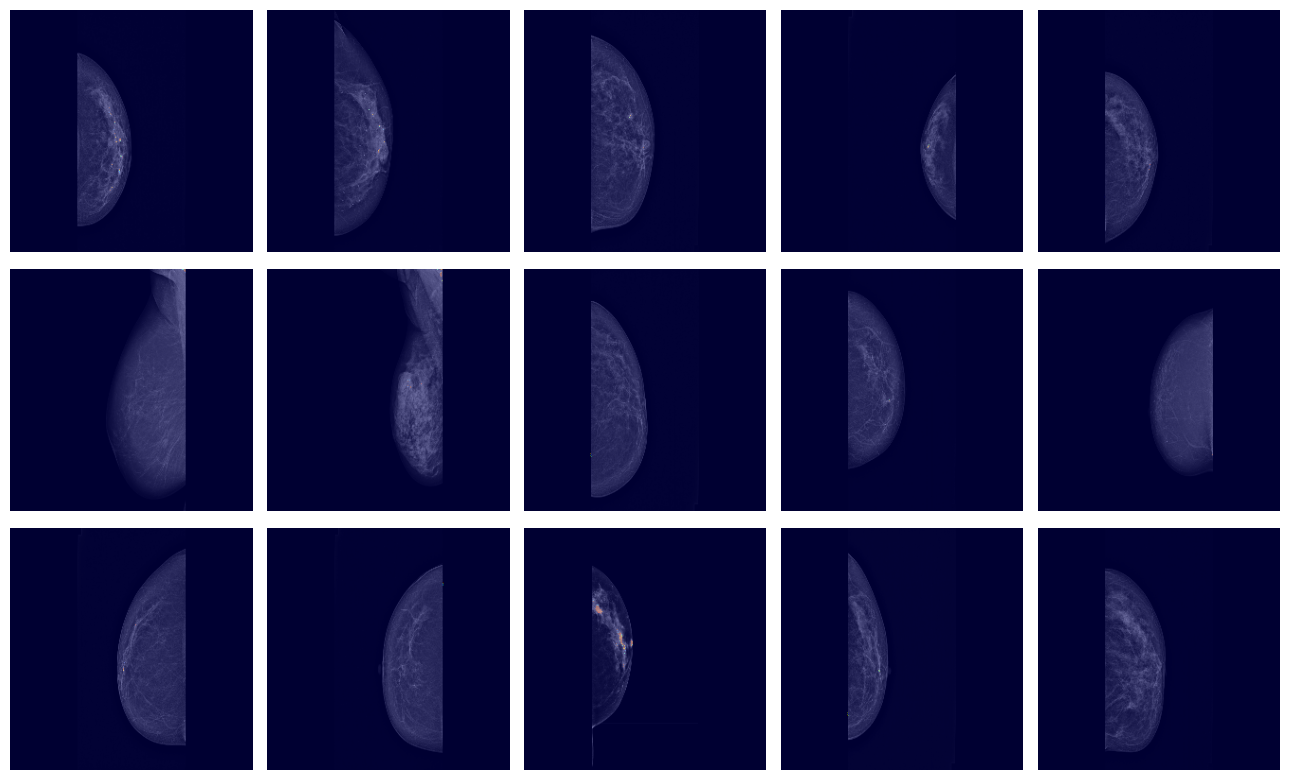

In [18]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='jet')
plt.tight_layout()
plt.show()

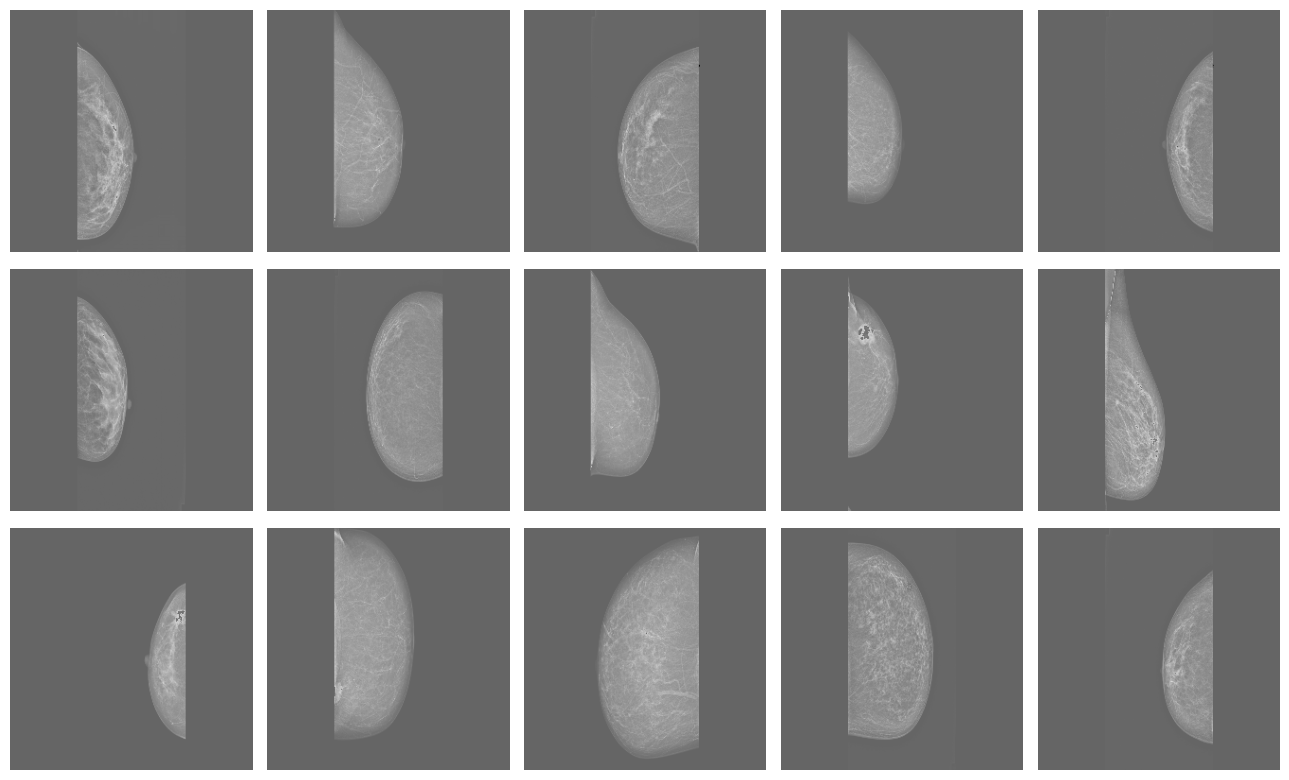

In [19]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='binary')
plt.tight_layout()
plt.show()

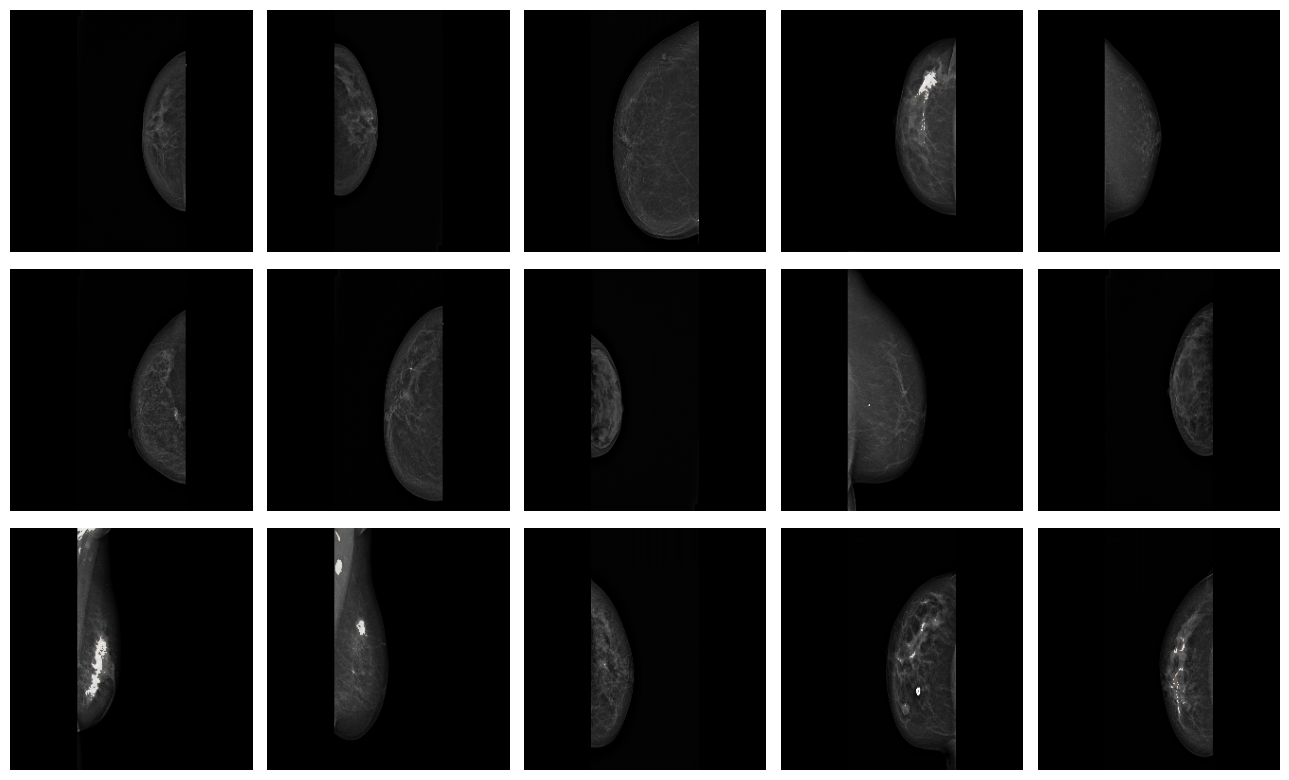

In [20]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='afmhot')
plt.tight_layout()
plt.show()

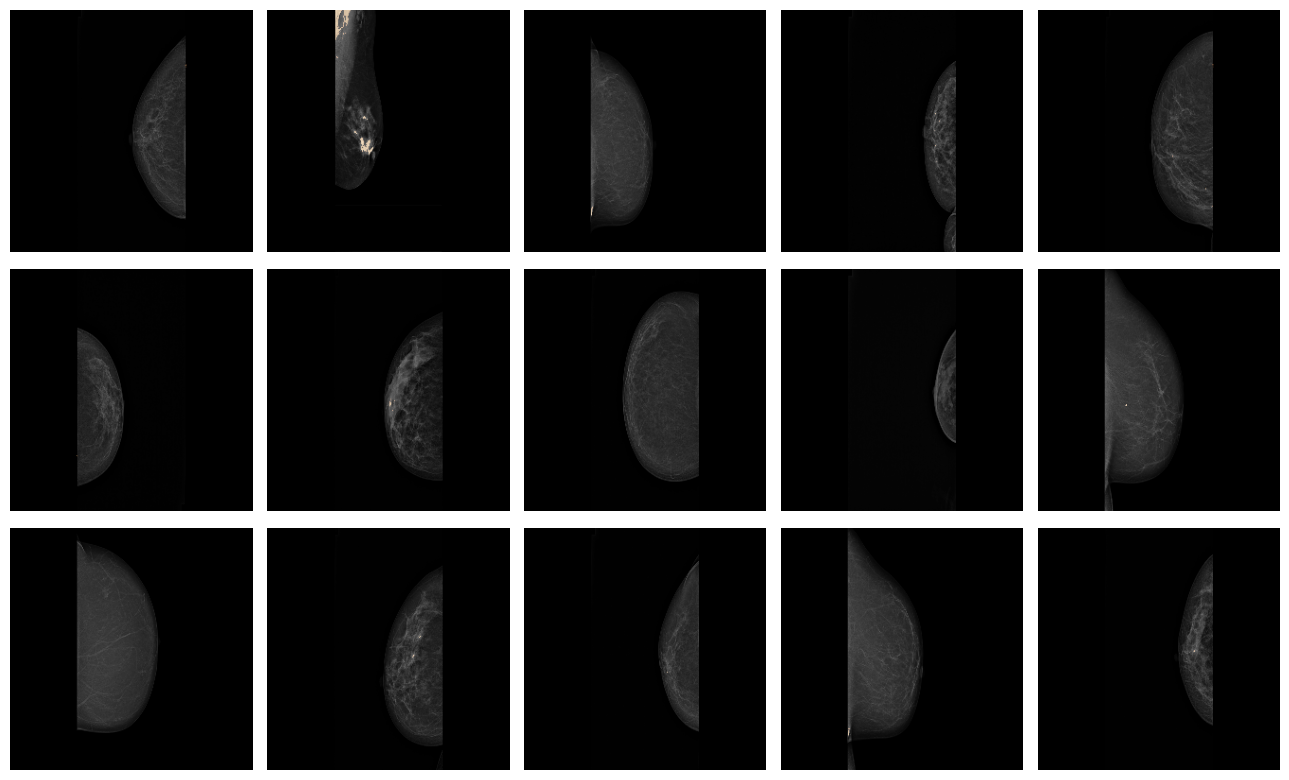

In [21]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='copper')
plt.tight_layout()
plt.show()

In [22]:
#encoder
class EncoderBlock(Layer):

    def __init__(self, filters, rate, pooling=True, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate
        self.pooling = pooling

        self.c1 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.drop = Dropout(rate)
        self.c2 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.pool = MaxPool2D()

    def call(self, X):
        x = self.c1(X)
        x = self.drop(x)
        x = self.c2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
            'pooling':self.pooling
        }


In [23]:
#decoder
class DecoderBlock(Layer):

    def __init__(self, filters, rate, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate

        self.up = UpSampling2D()
        self.net = EncoderBlock(filters, rate, pooling=False)

    def call(self, X):
        X, skip_X = X
        x = self.up(X)
        c_ = concatenate([x, skip_X])
        x = self.net(c_)
        return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
        }

In [24]:
class AttentionGate(Layer):

    def __init__(self, filters, bn, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)

        self.filters = filters
        self.bn = bn

        self.normal = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.down = Conv2D(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')
        self.learn = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')
        self.resample = UpSampling2D()
        self.BN = BatchNormalization()

    def call(self, X):
        X, skip_X = X

        x = self.normal(X)
        skip = self.down(skip_X)
        x = Add()([x, skip])
        x = self.learn(x)
        x = self.resample(x)
        f = Multiply()([x, skip_X])
        if self.bn:
            return self.BN(f)
        else:
            return f
        # return f

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "bn":self.bn
        }

In [25]:

class ShowProgress(Callback):
    def on_epoch_end(self, epochs, logs=None):
        id = np.random.randint(200)
        exp = GradCAM()
        image = images[id]
        mask = masks[id]
        pred_mask = self.model.predict(image[np.newaxis,...])
        cam = exp.explain(
            validation_data=(image[np.newaxis,...], mask),
            class_index=1,
            layer_name='Attention4',
            model=self.model
        )

        plt.figure(figsize=(10,5))

        plt.subplot(1,3,1)
        plt.title("Original Mask")
        show_mask(image, mask, cmap='copper')

        plt.subplot(1,3,2)
        plt.title("Predicted Mask")
        show_mask(image, pred_mask, cmap='copper')

        plt.subplot(1,3,3)
        show_image(cam,title="GradCAM")

        plt.tight_layout()
        plt.show()


In [26]:
input_layer = Input(shape=images.shape[-3:])

# Encoder
p1, c1 = EncoderBlock(32,0.1, name="Encoder1")(input_layer)
p2, c2 = EncoderBlock(64,0.1, name="Encoder2")(p1)
p3, c3 = EncoderBlock(128,0.2, name="Encoder3")(p2)
p4, c4 = EncoderBlock(256,0.2, name="Encoder4")(p3)

# Encoding
encoding = EncoderBlock(512,0.3, pooling=False, name="Encoding")(p4)

# Attention + Decoder

a1 = AttentionGate(256, bn=True, name="Attention1")([encoding, c4])-
d1 = DecoderBlock(256,0.2, name="Decoder1")([encoding, a1])

a2 = AttentionGate(128, bn=True, name="Attention2")([d1, c3])
d2 = DecoderBlock(128,0.2, name="Decoder2")([d1, a2])

a3 = AttentionGate(64, bn=True, name="Attention3")([d2, c2])
d3 = DecoderBlock(64,0.1, name="Decoder3")([d2, a3])


a4 = AttentionGate(32, bn=True, name="Attention4")([d3, c1])
d4 = DecoderBlock(32,0.1, name="Decoder4")([d3, a4])

# Output 
output_layer = Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')(d4)

# Model
model = Model(
    inputs=[input_layer],
    outputs=[output_layer]
)

# Compile
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', MeanIoU(num_classes=2, name='IoU')]
)


In [27]:
import numpy as np
from tf_explain.core.grad_cam import GradCAM

original_get_gradients_and_filters = GradCAM.get_gradients_and_filters

def patched_get_gradients_and_filters(model, images, layer_name, class_index, use_guided_grads):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        inputs = tf.cast(images, tf.float32)
        tape.watch(inputs)
        conv_outputs, predictions = grad_model(inputs)
        
        #  Patch: if output is a list, get first element
        if isinstance(predictions, list):
            predictions = predictions[0]
        
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)

    if use_guided_grads:
        grads = tf.cast(conv_outputs > 0, "float32") * tf.cast(grads > 0, "float32") * grads

    return conv_outputs, grads

# Apply the patch
GradCAM.get_gradients_and_filters = staticmethod(patched_get_gradients_and_filters)

In [28]:
cb = [
    ModelCheckpoint("AttentionCustomUNet.keras", save_best_only=True),
    ShowProgress()
]

Epoch 1/20


2025-06-21 09:25:38.563524: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


/home/vidi/leetcode/project/image_processing/cnn/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=['Tensor(shape=(1, 256, 256, 3))']
  warnings.warn(msg)


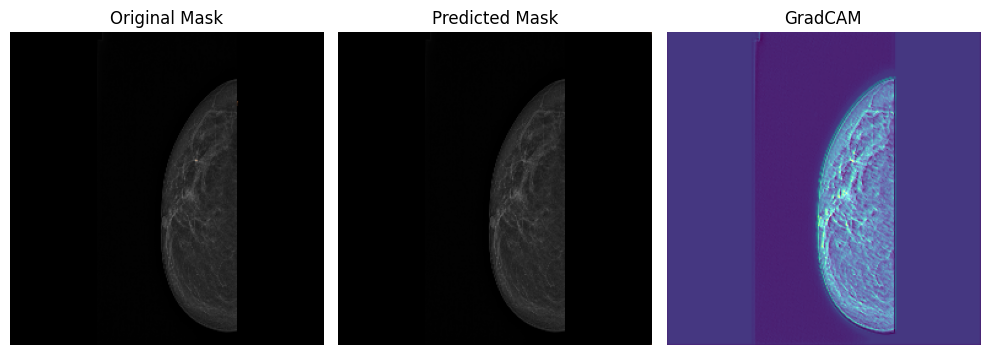

75/75 ━━━━━━━━━━━━━━━━━━━━ 412s 5s/step - IoU: 0.4999 - accuracy: 0.9972 - loss: 0.0681 - val_IoU: 0.5000 - val_accuracy: 0.9997 - val_loss: 0.0022
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


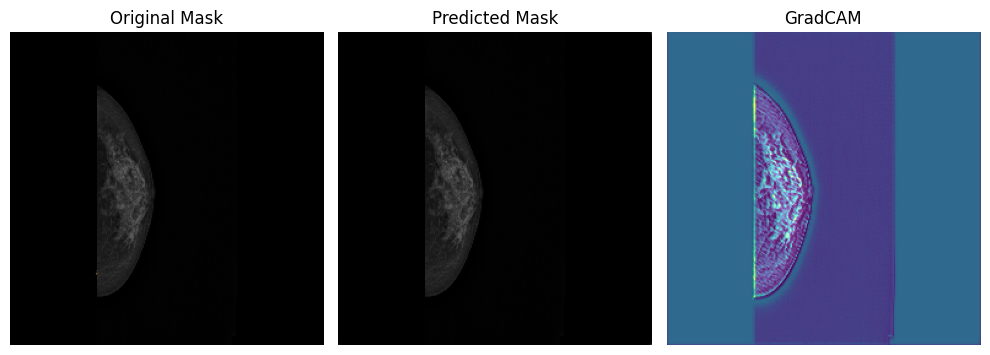

75/75 ━━━━━━━━━━━━━━━━━━━━ 393s 5s/step - IoU: 0.4999 - accuracy: 0.9988 - loss: 0.0028 - val_IoU: 0.5000 - val_accuracy: 0.9997 - val_loss: 0.0011
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


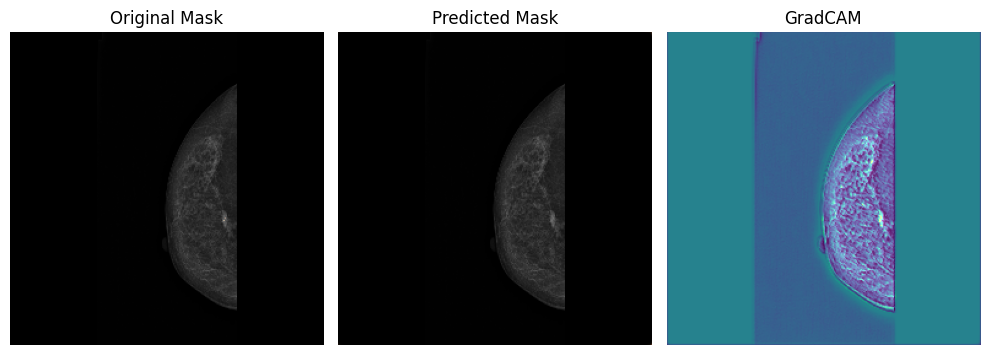

75/75 ━━━━━━━━━━━━━━━━━━━━ 381s 5s/step - IoU: 0.4999 - accuracy: 0.9987 - loss: 0.0018 - val_IoU: 0.5000 - val_accuracy: 0.9997 - val_loss: 8.4029e-04
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


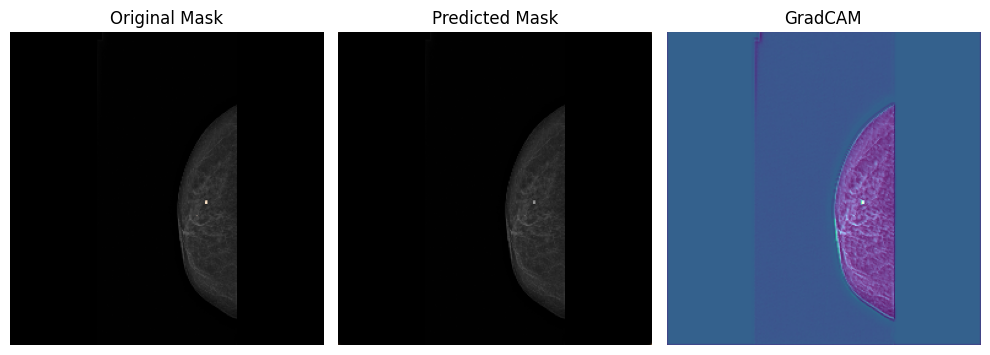

75/75 ━━━━━━━━━━━━━━━━━━━━ 466s 6s/step - IoU: 0.4999 - accuracy: 0.9989 - loss: 0.0015 - val_IoU: 0.5000 - val_accuracy: 0.9997 - val_loss: 7.7287e-04
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


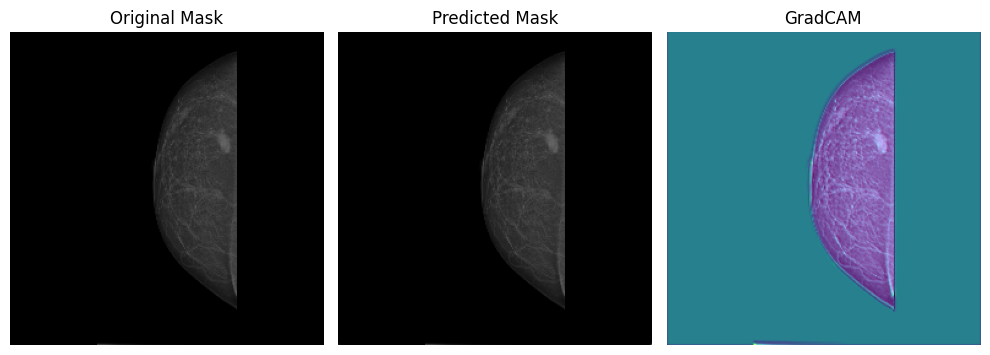

75/75 ━━━━━━━━━━━━━━━━━━━━ 445s 6s/step - IoU: 0.4999 - accuracy: 0.9990 - loss: 0.0010 - val_IoU: 0.5000 - val_accuracy: 0.9997 - val_loss: 3.4849e-04
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


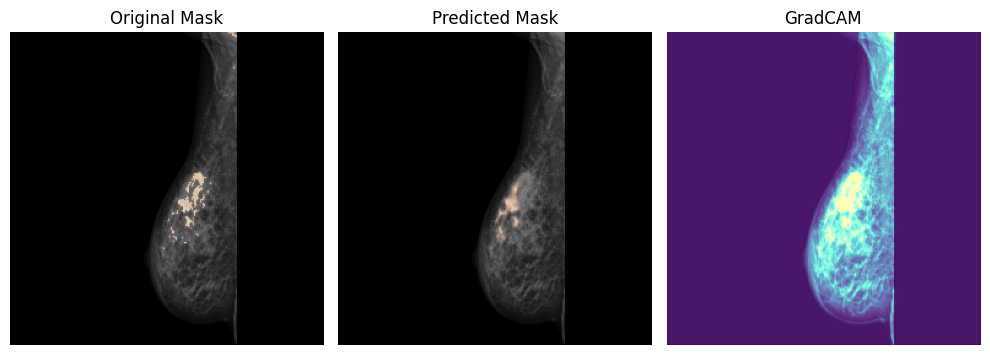

75/75 ━━━━━━━━━━━━━━━━━━━━ 374s 5s/step - IoU: 0.4999 - accuracy: 0.9990 - loss: 9.8560e-04 - val_IoU: 0.5000 - val_accuracy: 0.9997 - val_loss: 5.6249e-04
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


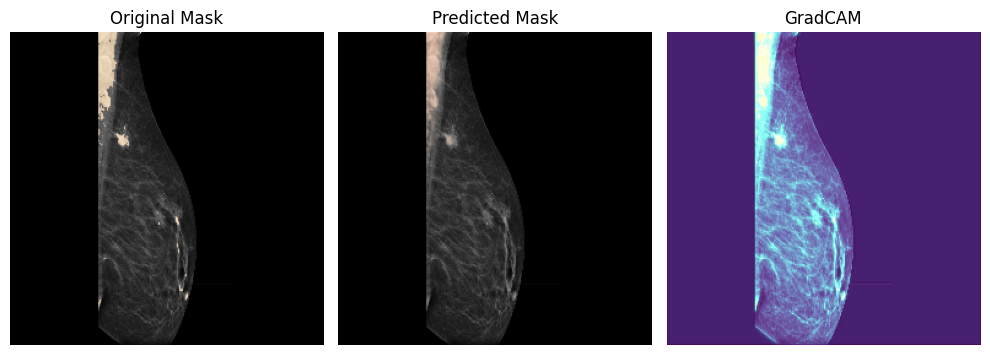

75/75 ━━━━━━━━━━━━━━━━━━━━ 375s 5s/step - IoU: 0.4999 - accuracy: 0.9990 - loss: 0.0010 - val_IoU: 0.5000 - val_accuracy: 0.9997 - val_loss: 2.9523e-04
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


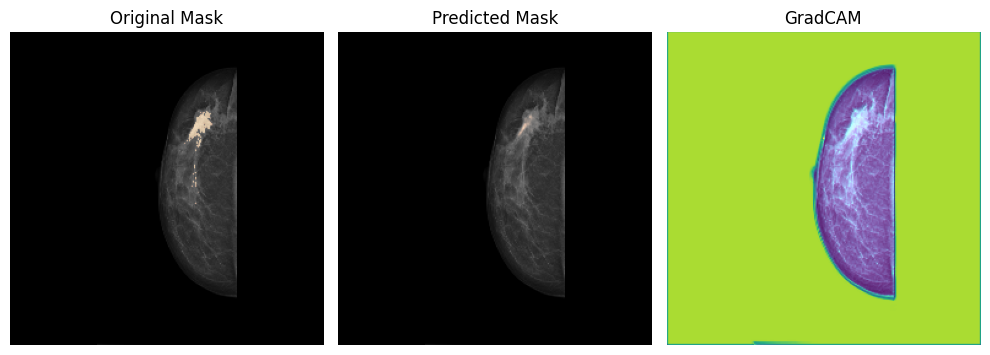

75/75 ━━━━━━━━━━━━━━━━━━━━ 376s 5s/step - IoU: 0.4999 - accuracy: 0.9988 - loss: 0.0012 - val_IoU: 0.5000 - val_accuracy: 0.9997 - val_loss: 2.7697e-04
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


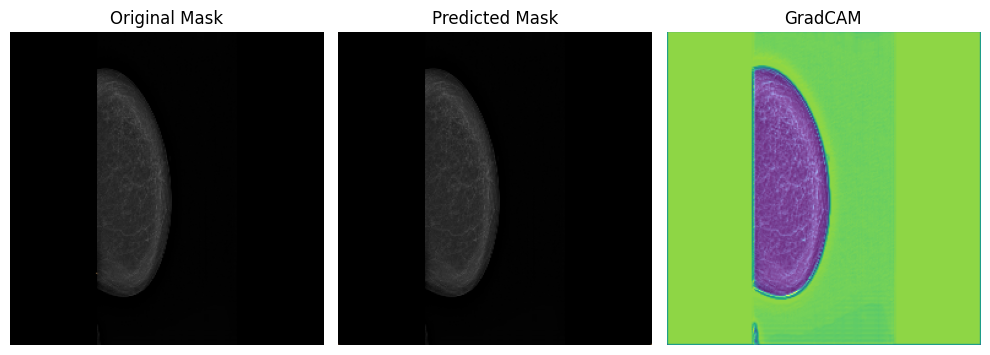

75/75 ━━━━━━━━━━━━━━━━━━━━ 376s 5s/step - IoU: 0.4999 - accuracy: 0.9989 - loss: 8.7900e-04 - val_IoU: 0.5000 - val_accuracy: 0.9997 - val_loss: 2.2294e-04
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


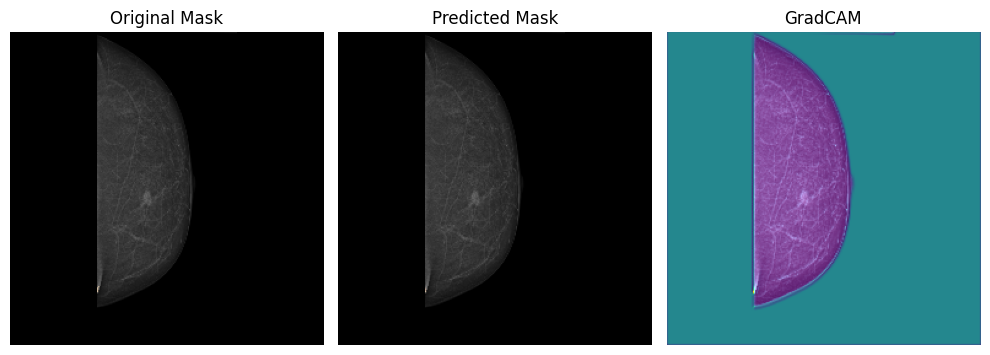

75/75 ━━━━━━━━━━━━━━━━━━━━ 389s 5s/step - IoU: 0.4999 - accuracy: 0.9990 - loss: 6.9838e-04 - val_IoU: 0.5000 - val_accuracy: 0.9997 - val_loss: 3.3542e-04
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


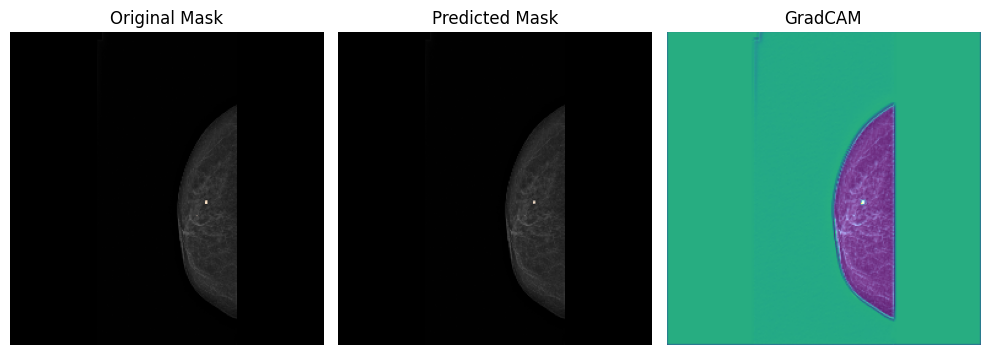

75/75 ━━━━━━━━━━━━━━━━━━━━ 1029s 14s/step - IoU: 0.4999 - accuracy: 0.9987 - loss: 0.0011 - val_IoU: 0.5000 - val_accuracy: 0.9997 - val_loss: 1.7747e-04
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


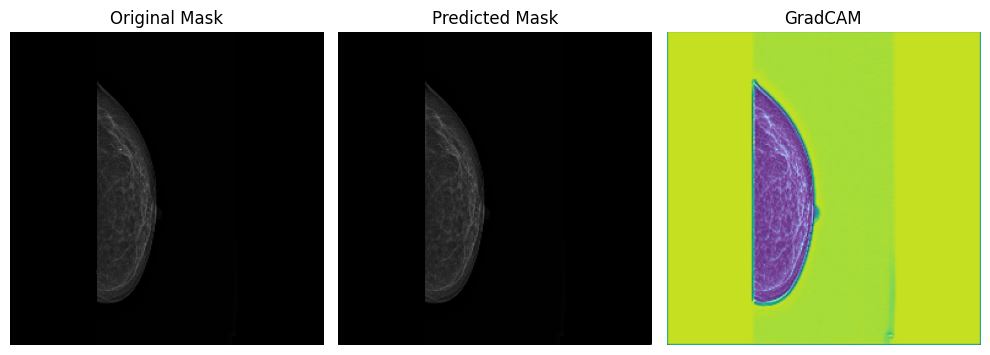

75/75 ━━━━━━━━━━━━━━━━━━━━ 374s 5s/step - IoU: 0.4999 - accuracy: 0.9989 - loss: 8.8650e-04 - val_IoU: 0.5000 - val_accuracy: 0.9997 - val_loss: 2.0299e-04
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


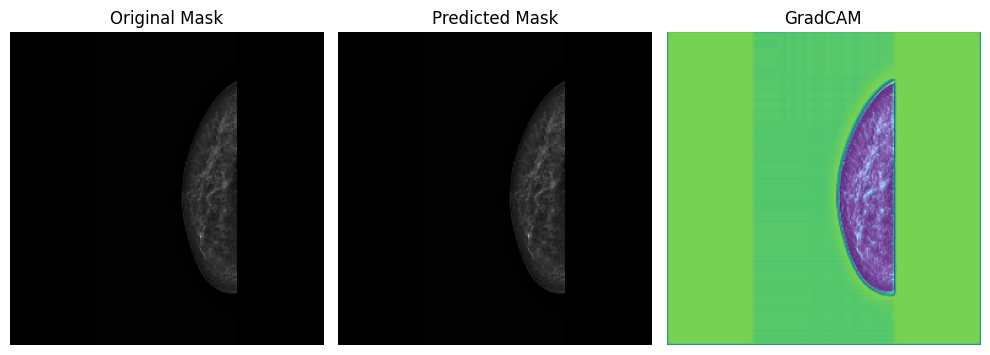

75/75 ━━━━━━━━━━━━━━━━━━━━ 375s 5s/step - IoU: 0.4999 - accuracy: 0.9990 - loss: 8.4673e-04 - val_IoU: 0.5000 - val_accuracy: 0.9997 - val_loss: 1.5028e-04
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


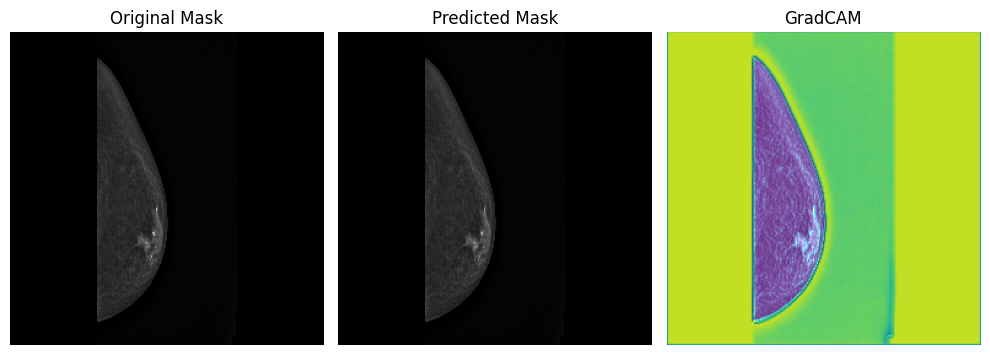

75/75 ━━━━━━━━━━━━━━━━━━━━ 1340s 18s/step - IoU: 0.4999 - accuracy: 0.9991 - loss: 5.7084e-04 - val_IoU: 0.5000 - val_accuracy: 0.9997 - val_loss: 1.0631e-04
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


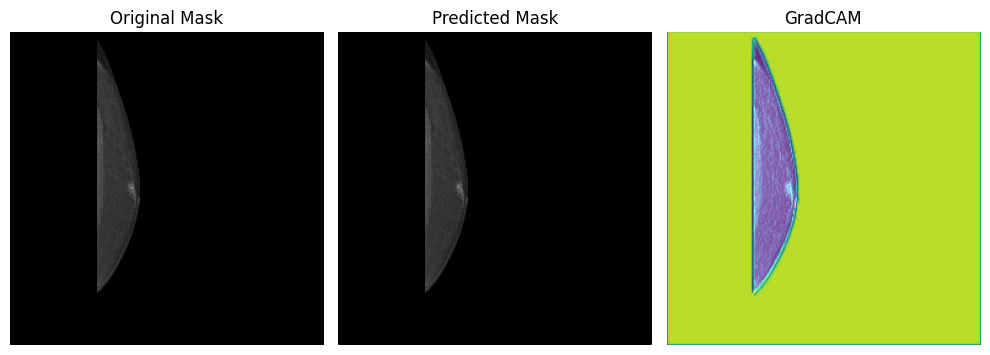

75/75 ━━━━━━━━━━━━━━━━━━━━ 373s 5s/step - IoU: 0.4999 - accuracy: 0.9990 - loss: 6.5723e-04 - val_IoU: 0.5000 - val_accuracy: 0.9997 - val_loss: 1.2890e-04
Epoch 16/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


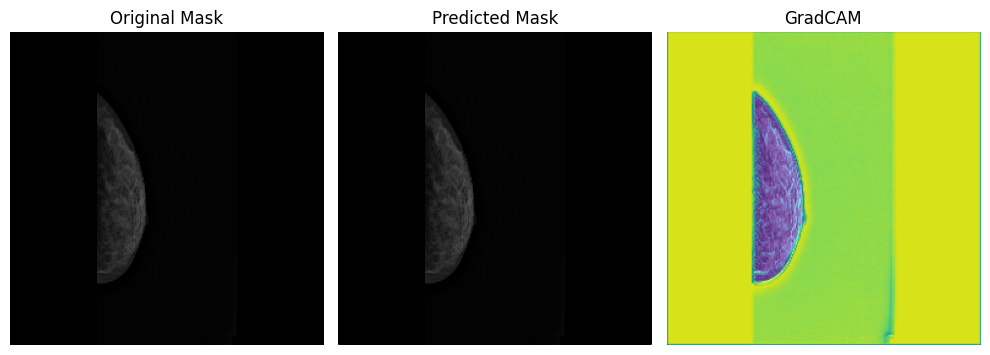

75/75 ━━━━━━━━━━━━━━━━━━━━ 373s 5s/step - IoU: 0.4999 - accuracy: 0.9989 - loss: 6.4759e-04 - val_IoU: 0.5000 - val_accuracy: 0.9997 - val_loss: 1.8987e-04
Epoch 17/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


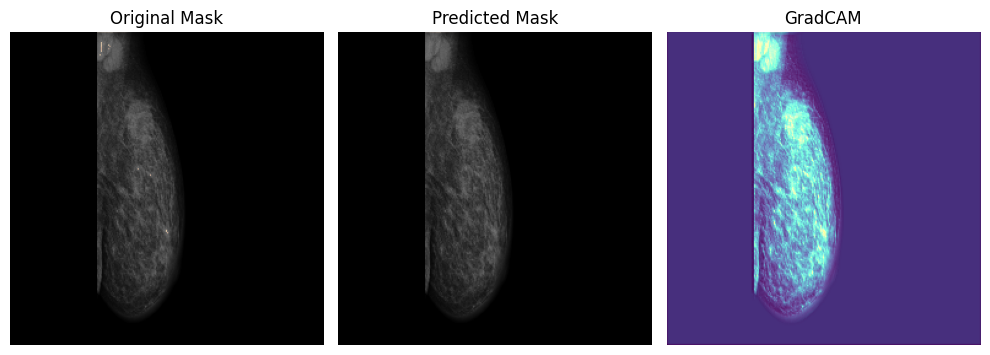

75/75 ━━━━━━━━━━━━━━━━━━━━ 1817s 24s/step - IoU: 0.4999 - accuracy: 0.9989 - loss: 7.5122e-04 - val_IoU: 0.5000 - val_accuracy: 0.9997 - val_loss: 1.7721e-04
Epoch 18/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


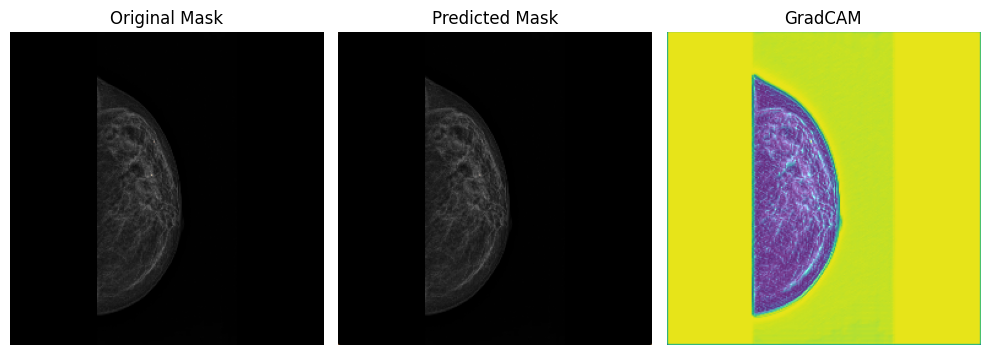

75/75 ━━━━━━━━━━━━━━━━━━━━ 376s 5s/step - IoU: 0.4999 - accuracy: 0.9991 - loss: 4.6841e-04 - val_IoU: 0.5000 - val_accuracy: 0.9997 - val_loss: 2.7608e-04
Epoch 19/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


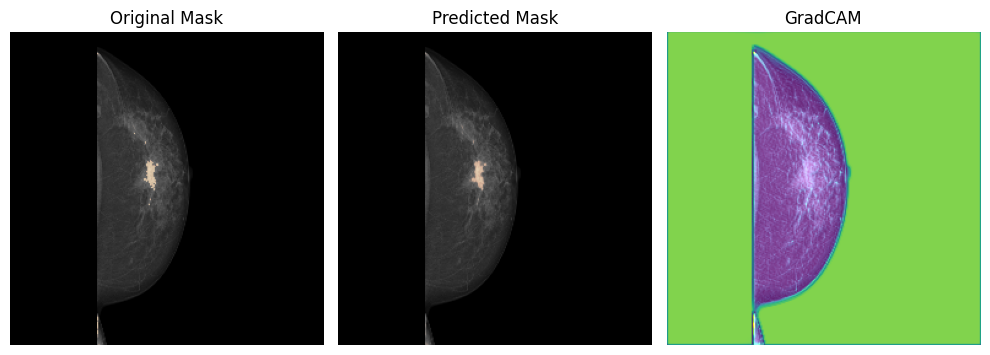

75/75 ━━━━━━━━━━━━━━━━━━━━ 376s 5s/step - IoU: 0.4999 - accuracy: 0.9991 - loss: 4.8517e-04 - val_IoU: 0.5000 - val_accuracy: 0.9997 - val_loss: 7.4864e-05
Epoch 20/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


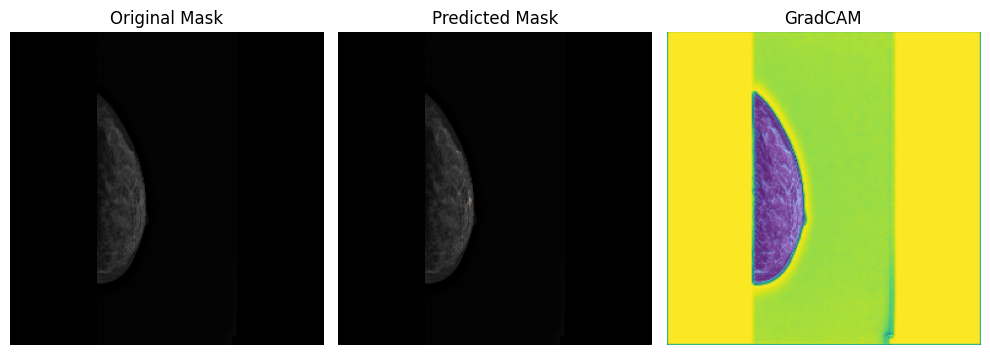

75/75 ━━━━━━━━━━━━━━━━━━━━ 373s 5s/step - IoU: 0.4999 - accuracy: 0.9990 - loss: 6.0913e-04 - val_IoU: 0.5000 - val_accuracy: 0.9997 - val_loss: 1.6380e-04


In [29]:
BATCH_SIZE = 8

results = model.fit(
    images, masks,
    validation_split=0.2,
    epochs=20,
    batch_size=BATCH_SIZE,
    callbacks=cb
)


In [238]:
from tensorflow.keras.models import load_model
model = load_model("AttentionCustomUNet.keras", compile=False)

TypeError: <class 'keras.src.models.functional.Functional'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {}, 'registered_name': 'Functional', 'build_config': {'input_shape': None}, 'compile_config': None}.

Exception encountered: Could not locate class 'EncoderBlock'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': None, 'class_name': 'EncoderBlock', 'config': {'name': 'Encoder1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'filters': 32, 'rate': 0.1, 'pooling': True}, 'registered_name': 'EncoderBlock', 'build_config': {'input_shape': [None, 256, 256, 3]}, 'name': 'Encoder1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 256, 3], 'dtype': 'float32', 'keras_history': ['input_layer', 0, 0]}}], 'kwargs': {}}]}

In [30]:
loss, accuracy, iou, val_loss, val_accuracy, val_iou = results.history.values()

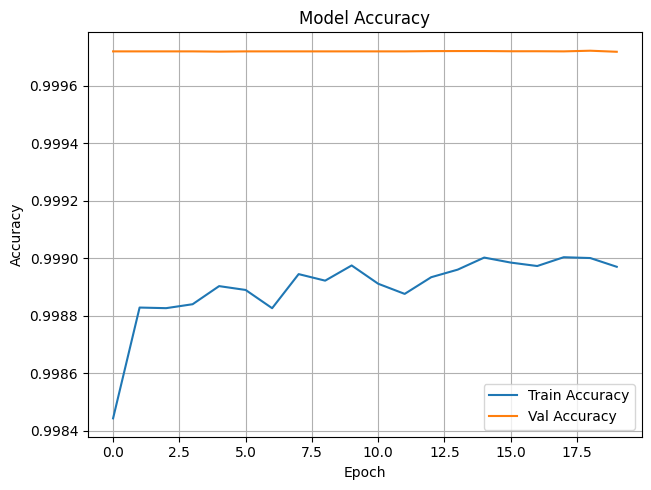

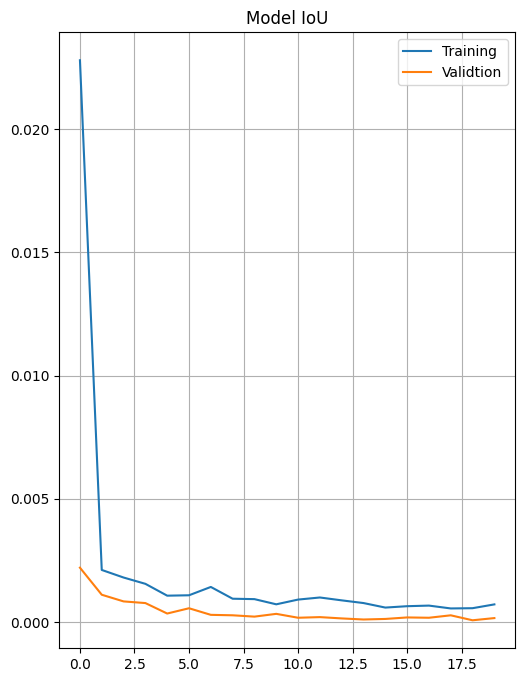

In [183]:
import matplotlib.pyplot as plt

# Plot training metrics
plt.figure(figsize=(18, 5))

# Accuracy
plt.subplot(1, 3, 1)
plt.plot(accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()

plt.figure(figsize=(20,8))

plt.subplot(1,3,3)
plt.title("Model IoU")
plt.plot(iou, label="Training")
plt.plot(val_iou, label="Validtion")
plt.legend()
plt.grid()

plt.show()

325
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
Image path: images/Non-Cancer/IMG (28).jpg
14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
Image path: images/Cancer/IMG (111).jpg
74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
Image path: images/Cancer/IMG (53).jpg
450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
Image path: images/Non-Cancer/IMG (392).jpg
482
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
Image path: images/Non-Cancer/IMG (420).jpg


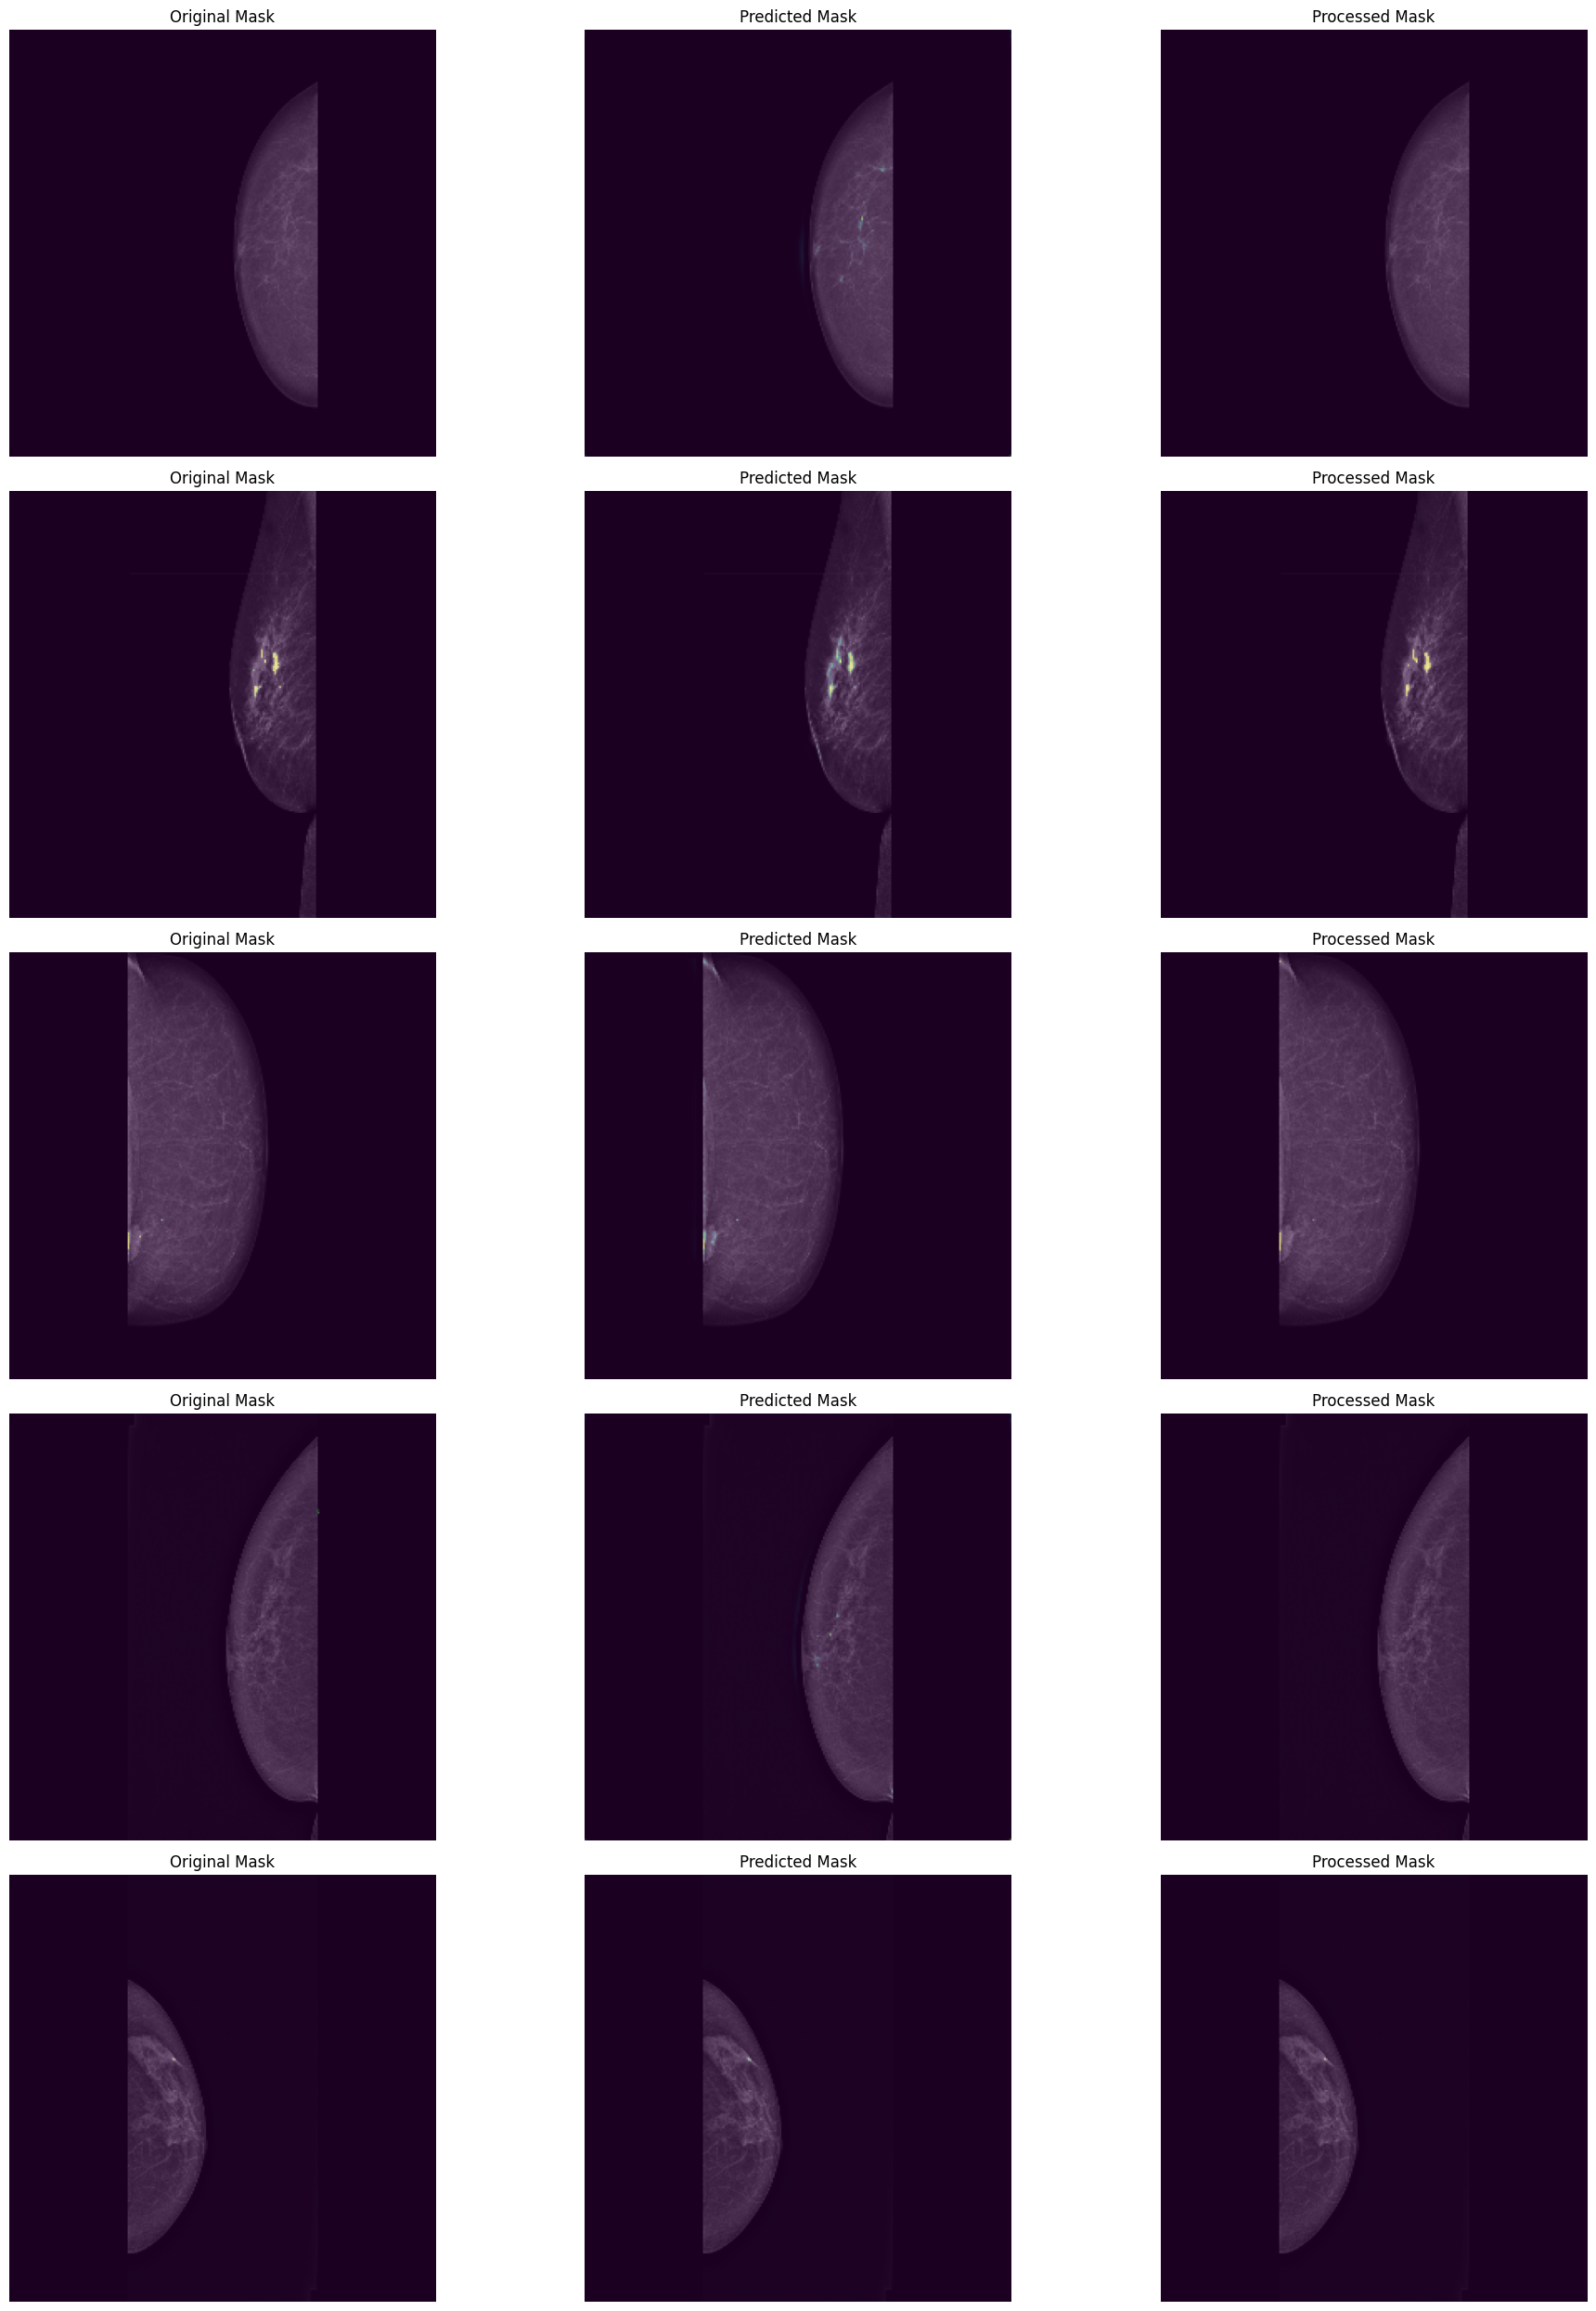

In [155]:
plt.figure(figsize=(20,25))
n=0
for i in range(1,(5*3)+1):
    plt.subplot(5,3,i)
    if n==0:
        id = np.random.randint(len(images))
        print(id)
        image = images[id]
        mask = masks[id]
        pred_mask = model.predict(image[np.newaxis,...])
       #added this 
        print(f"Image path: {image_paths[id]}")
        plt.title("Original Mask")
        show_mask(image, mask)
        n+=1
    elif n==1:
        plt.title("Predicted Mask")
        show_mask(image, pred_mask)
        n+=1
    elif n==2:
        pred_mask = (pred_mask>0.5).astype('float')
        plt.title("Processed Mask")
        show_mask(image, pred_mask)
        n=0
plt.tight_layout()
plt.show()

In [33]:
import cv2

def is_cancerous(mask_path, threshold_area=50):
    """
    Determines whether the mask indicates a cancerous image.
    
    Args:
        mask_path (str): Path to the predicted mask image.
        threshold_area (int): Minimum area in pixels to consider as tumor.

    Returns:
        bool: True if cancerous, False otherwise.
    """
    # Load the mask (grayscale)
   # mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    print("Unique pixel values in mask:", np.unique(mask),end="\n\n")
    
    # Threshold the mask to binary (0 or 255)
    _, binary_mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)
    
    # Find contours in the binary mask
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate total tumor area
    total_area = sum(cv2.contourArea(cnt) for cnt in contours)

    # Check if area exceeds the threshold
    return total_area > threshold_area

In [34]:
#estimating the tumor size 
def estimate_tumor_size(mask, pixel_spacing=None):
    """
    Args:
        mask: (H, W) numpy array with binary mask (values 0 or 1)
        pixel_spacing: tuple (row_spacing_mm, col_spacing_mm), optional
    Returns:
        Dictionary with tumor area, bbox, centroid, etc.
    """
    # Threshold and convert to uint8
    binary_mask = (mask > 0.5).astype(np.uint8)

    # Find contours
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return {"tumor_area_px": 0, "bounding_box": None, "centroid": None}

    largest_contour = max(contours, key=cv2.contourArea)
    area_px = cv2.contourArea(largest_contour)
    x, y, w, h = cv2.boundingRect(largest_contour)
    M = cv2.moments(largest_contour)
    
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
    else:
        cx, cy = None, None

    result = {
        "tumor_area_px": area_px,
        "bounding_box": (x, y, w, h),
        "centroid": (cx, cy),
    }

    if pixel_spacing:  # (e.g. (0.5 mm, 0.5 mm))
        mm2_per_pixel = pixel_spacing[0] * pixel_spacing[1]
        area_mm2 = area_px * mm2_per_pixel
        result["tumor_area_mm2"] = area_mm2
        result["tumor_area_cm2"] = area_mm2 / 100.0

    return result

In [119]:
def fetch_stage_recommendation_from_db(stage_number):
    conn = None
    cursor = None

    try:
        conn = psycopg2.connect(
            dbname="vidi",
            user="vidi",
            password="root",  
            host="localhost",
            port="5432"
        )
        cursor = conn.cursor()
        cursor.execute(
            "SELECT stage, diet, exercise, yoga FROM diet_plan WHERE stage = %s;",
            (stage_number,)
        )
        row = cursor.fetchone()

        if row:
            return row[0], row[1], row[2], row[3]  # stage, diet, exercise, yoga
        else:
            return stage_number, "Not found", "Not found", "Not found"

    except Exception as e:
        return stage_number, f"Database error: {e}", "", ""

    finally:
        if cursor:
            cursor.close()
        if conn:
            conn.close()


In [163]:
def wrap_text_every_n_words(text, n=15):
    words = text.split()
    lines = [' '.join(words[i:i+n]) for i in range(0, len(words), n)]
    return lines

# --- Save report to PDF ---
def save_report_to_pdf(report_text_lines, image_for_pdf, filename="diagnosis_report.pdf"):
    import cv2
    from PIL import Image

    # Save image to temp file
    temp_img_path = tempfile.NamedTemporaryFile(suffix=".png", delete=False).name
    plt.figure(figsize=(6, 6))
    plt.imshow(image_for_pdf)
    plt.title("Tumor Bounding Box and Centroid")
    plt.axis('off')
    plt.savefig(temp_img_path, bbox_inches='tight')
    plt.close()

    # Setup PDF
    c = canvas.Canvas(filename, pagesize=A4)
    width, height = A4
    x_margin = 50
    y = height - 50
    line_spacing = 15

    # Estimate text height
    text_height = len(report_text_lines) * line_spacing
    img_height = 250
    buffer = 50

    # Check if there's enough room for image on same page
    lines_before_image = []
    lines_after_centroid = []
    image_drawn = False
    draw_image_now = False

    for line in report_text_lines:
        lines_before_image.append(line)
        if "Centroid:" in line and not image_drawn:
            lines_after_centroid = report_text_lines[report_text_lines.index(line)+1:]
            space_needed = img_height + buffer
            remaining_height = y - len(lines_after_centroid)*line_spacing
            draw_image_now = remaining_height > space_needed
            break

    # Draw all lines (including up to centroid)
    for line in report_text_lines:
        if y < 100:
            c.showPage()
            y = height - 50
        c.drawString(x_margin, y, line)
        y -= line_spacing

        if "Centroid:" in line and not image_drawn:
            if draw_image_now:
                # Draw image below centroid
                y -= 20
                c.drawImage(ImageReader(temp_img_path),
                            x_margin,
                            y - img_height,
                            width=300,
                            height=img_height,
                            preserveAspectRatio=True)
                y -= img_height + 30
            else:
                c.showPage()
                y = height - 50
                c.drawString(x_margin, y, "Tumor Bounding Box and Centroid")
                y -= 20
                c.drawImage(ImageReader(temp_img_path),
                            (width - 300) // 2,
                            y - img_height,
                            width=300,
                            height=img_height,
                            preserveAspectRatio=True)
                y -= img_height + 30
            image_drawn = True

    c.save()
    print(f"✅ PDF saved: {filename}")



In [209]:
# --- Estimate tumor size, location, and report info ---
def run_diagnosis(image_path, processed_mask, cancer_status):
    report_lines = []

    # === Load the image from file ===
    image = cv2.imread(image_path)
    image = cv2.resize(image, (256, 256))  
    image_normalized = image / 255.0      
    annotated_image = image.copy()

    if cancer_status == 1:
        report_lines += ["Image is Cancerous"]
        print("Now detecting tumor size...")

        tumor_info = estimate_tumor_size(processed_mask, pixel_spacing=(0.5, 0.5))

        tumor_area_px = tumor_info['tumor_area_px']
        pixel_spacing_mm = 0.5
        area_cm2 = tumor_area_px * (pixel_spacing_mm ** 2) / 100
        diameter_cm = 2 * np.sqrt(area_cm2 / np.pi)

        report_lines += [
            f"Tumor area (pixels): {tumor_area_px:.2f}",
            f"Tumor Area = {area_cm2:.2f} cm²",
            f"Tumor diameter = {diameter_cm:.2f} cm"
        ]

        # Estimate stage
        if diameter_cm <= 2:
            stage = 1
        elif diameter_cm <= 5:
            stage = 2
        else:
            stage = 3

        report_lines += [f"Estimated Cancer Stage: T{stage}", "", f"STAGE: {stage}"]

        # Recommendations from database
        stage_num, diet, exercise, yoga = fetch_stage_recommendation_from_db(stage)

        report_lines += ["\nDIET:"]
        report_lines += wrap_text_every_n_words(diet.strip(), n=10)

        report_lines += ["\nEXERCISE:"]
        report_lines += wrap_text_every_n_words(exercise.strip(), n=10)

        report_lines += ["\nYOGA:"]
        report_lines += wrap_text_every_n_words(yoga.strip(), n=5)

        # Annotate image
        bbox = tumor_info['bounding_box']
        centroid = tumor_info['centroid']
        report_lines += [
            f"\nBounding Box: {bbox}",
            f"Centroid: {centroid}"
        ]

        x, y, w, h = bbox
        cv2.rectangle(annotated_image, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv2.circle(annotated_image, centroid, 5, (0, 0, 255), -1)

        # Optional preview
        plt.figure(figsize=(6, 6))
        plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
        plt.title("Tumor Bounding Box and Centroid")
        plt.axis('off')
        plt.show()

    else:
        report_lines = ["Image is Non-Cancerous"]
        stage = 0

        # Recommendations
        stage_num, diet, exercise, yoga = fetch_stage_recommendation_from_db(stage)

        report_lines += ["\nDIET:"]
        report_lines += wrap_text_every_n_words(diet.strip(), n=10)

        report_lines += ["\nEXERCISE:"]
        report_lines += wrap_text_every_n_words(exercise.strip(), n=10)

        report_lines += ["\nYOGA:"]
        report_lines += wrap_text_every_n_words(yoga.strip(), n=5)

        report_lines += [f"\nStay healthy and exercise"]

    # === Save report to PDF ===
    save_report_to_pdf(report_lines, annotated_image)


In [176]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas
from reportlab.lib.utils import ImageReader
import tempfile
import psycopg2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


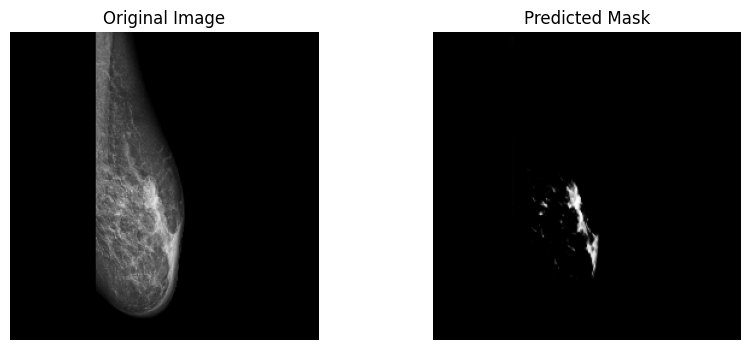

file_exixts: True
Unique pixel values in mask: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  25  28  36  37 227 231 234 235 236 237 238 239
 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255]

Image is CANCEROUS.


In [231]:
#id = 0
# Change this to the desired path
#mask = "sample/Cancer/IMG (44)_mask.jpg"
image_path = "sample/Cancer/IMG (87).jpg"

img = tf.keras.preprocessing.image.load_img(image_path, target_size=(256, 256))
img = tf.keras.preprocessing.image.img_to_array(img)
img = img / 255.0
img = tf.expand_dims(img, axis=0)

pred_mask = model.predict(img)
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(img[0])
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(pred_mask[0].squeeze(), cmap='gray')
plt.title("Predicted Mask")
plt.axis("off")

plt.show()

#processed_mask = (pred_mask[0] > 0.5).astype('float')  # Assuming shape (1, H, W, 1) or similar
processed_mask = (pred_mask[0] > 0.5).astype('float')  # Shape: (H, W, 1) or (H, W)
if processed_mask.ndim == 3 and processed_mask.shape[-1] == 1:
    processed_mask = np.squeeze(processed_mask, axis=-1)  # Now (H, W)

# Save the mask as an image
plt.imsave('predicted_mask.jpg', processed_mask, cmap='gray')

mask_path = "predicted_mask.jpg"
print("file_exixts:",os.path.exists(mask_path))

# checking the the image is cancerous or not  and setting the flag status 
cancer_status =0
if is_cancerous(mask_path):
    print("Image is CANCEROUS.")
    cancer_status = 1
else:
    print("Image is NON-CANCEROUS.")
    cancer_status = 0


Now detecting tumor size...


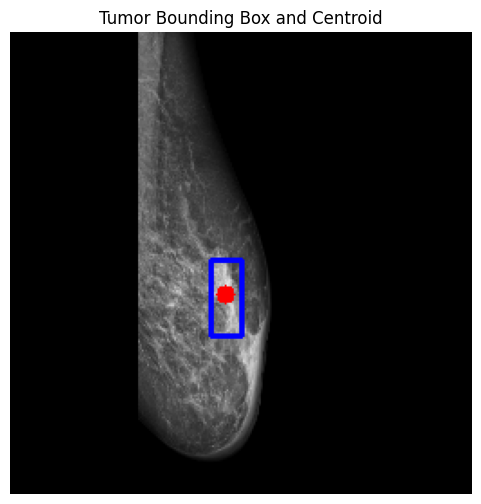

✅ PDF saved: diagnosis_report.pdf


In [232]:
# for running the diagnosis part 
run_diagnosis(image_path, processed_mask, cancer_status)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Confusion Matrix:
[[522508    162]
 [   174   1444]]


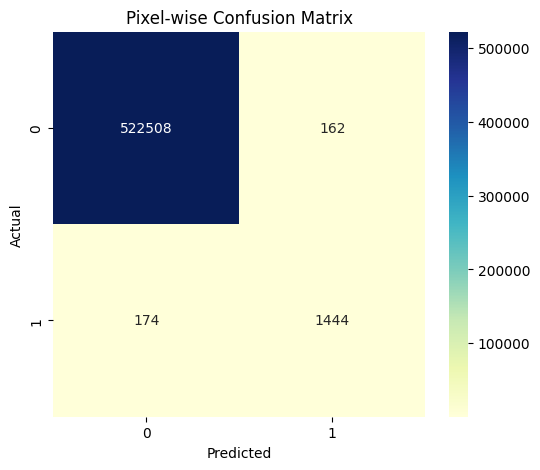

In [237]:
# Predict
preds = model.predict(images[:BATCH_SIZE])
preds_bin = (preds > 0.65).astype("int32")

# Convert masks to binary
masks_bin = (masks[:BATCH_SIZE] > 0.65).astype("int32")

# Flatten
y_true = masks_bin.flatten()
y_pred = preds_bin.flatten()

# Now compute confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Pixel-wise Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



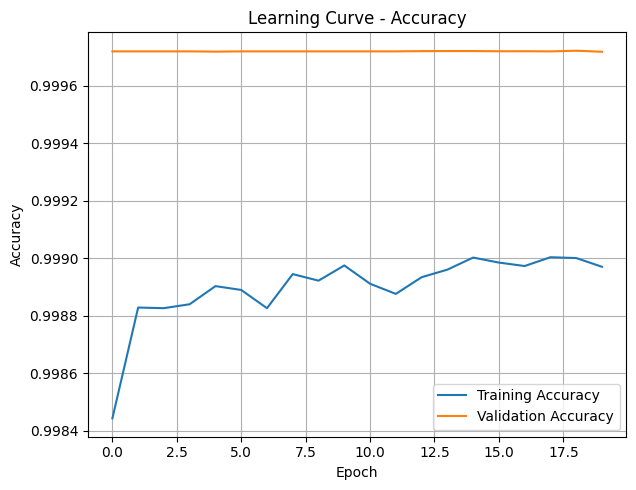

In [234]:
loss = results.history['loss']
val_loss = results.history['val_loss']
accuracy = results.history['accuracy']
val_accuracy = results.history['val_accuracy']
plt.figure(figsize=(12, 5))

#Accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Learning Curve - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)



plt.tight_layout()
plt.show()



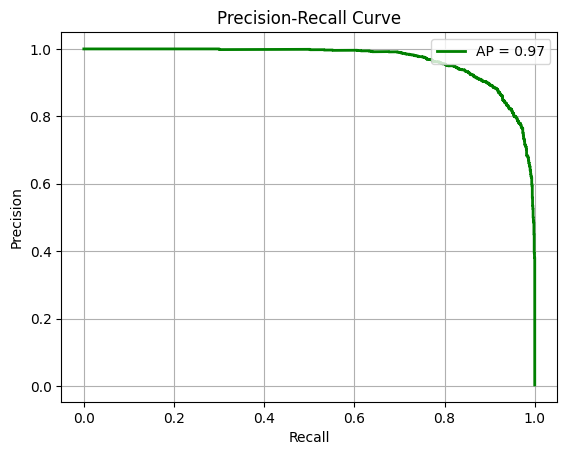

In [221]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Define y_score as predicted probabilities
y_score = preds[:BATCH_SIZE].flatten()
y_true = masks_bin.flatten() 

# Compute Precision-Recall
precision, recall, _ = precision_recall_curve(y_true, y_score)
avg_precision = average_precision_score(y_true, y_score)

# Plot
plt.figure()
plt.plot(recall, precision, lw=2, color='green', label=f'AP = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.grid()
plt.show()

In [222]:
iou_score = jaccard_score(y_true, y_pred)
print(f"IoU: {iou_score:.4f}")



IoU: 0.7712


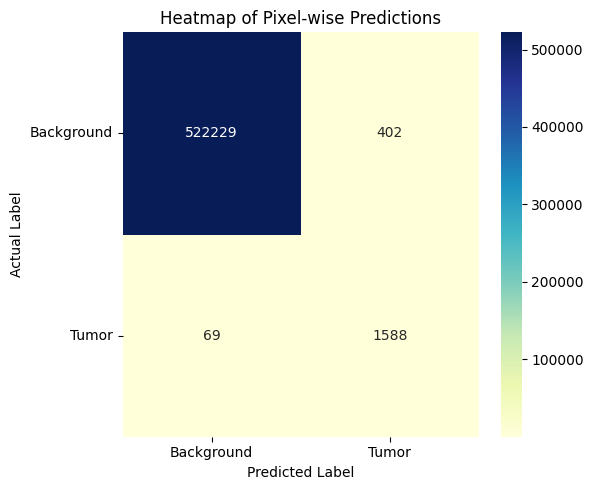

In [223]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Plot heatmap from previously computed `cm`
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', cbar=True)

plt.title('Heatmap of Pixel-wise Predictions')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.xticks([0.5, 1.5], ['Background', 'Tumor'])
plt.yticks([0.5, 1.5], ['Background', 'Tumor'], rotation=0)
plt.tight_layout()
plt.show()

plt.show()


In [47]:
!pip install psycopg2-binary


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 4.0 MB/s eta 0:00:00 MB/s eta 0:00:01:01m


In [78]:
!pip3 install reportlab


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.8 MB/s eta 0:00:0030.7 MB/s eta 0:00:01
